In [79]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

In [80]:
import torch
import pandas as pd
import numpy as np
import os
from dgl.data.utils import download, extract_archive, get_download_dir

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [81]:
_urls = {
    'ml-latest-small': 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
}

class MovieLens():
  def __init__(self, download_dir = '/content/', extract_dir = '',
               name='ml-latest-small', valid_ratio=0.1, test_ratio=0.1):
    self.test_ratio = test_ratio
    self.valid_ratio = valid_ratio
    self._download_and_extract(download_dir, extract_dir, name)
    self.all_ratings = self._load_raw_rates(
        os.path.join(download_dir, extract_dir, name, 'ratings.csv'), ',')
    self._preprocess_data()
    self._global_mean = self.all_ratings['rating'].mean()

  def _download_and_extract(self, download_dir, extract_dir, name):
    zip_file_path = f'{download_dir}/{name}.zip'
    download(_urls[name], path=zip_file_path)
    extract_archive(zip_file_path, extract_dir)


  def _load_raw_rates(self, file_path, sep):
    rating_info = pd.read_csv(
        file_path, sep=sep,
        engine='python')
    return rating_info

  def _preprocess_data(self):
    users = self.all_ratings['userId'].sort_values().unique()
    movieIds = self.all_ratings['movieId'].sort_values().unique()
    movieMap = {e: i+1 for i, e in enumerate(movieIds)}
    self._n_users = len(users)
    self._n_items = len(movieIds)
    self.all_ratings['movieId'] = self.all_ratings['movieId'].map(lambda e: movieMap[e])

  def split_train_test(self):
    self.test_data = self.all_ratings.sample(frac=self.test_ratio, random_state=200)
    self.all_train_data = self.all_ratings.drop(self.test_data.index).sample(frac=1.0)
    self.test_data = self.test_data.reset_index(drop=True)
    self.all_train_data = self.all_train_data.reset_index(drop=True)
    return self.all_train_data, self.test_data
  
  @property
  def n_users(self):
    return self._n_users
  
  @property
  def n_items(self):
   return self._n_items

  @property
  def global_mean(self):
    return self._global_mean

In [82]:
ml = MovieLens()
train_data, test_data = ml.split_train_test()
n_users = ml.n_users
n_items = ml.n_items
global_mean = ml.global_mean

Extracting file to 


# Model

In [83]:
class MatrixFactorization(torch.nn.Module):
  def __init__(self, global_mean, n_users, n_items, n_factors=20):
    super(MatrixFactorization, self).__init__()
    self.user_embeddings = torch.nn.Embedding(n_users+1, n_factors)
    self.item_embeddings = torch.nn.Embedding(n_items+1, n_factors)
    self.user_biases = torch.nn.Embedding(n_users+1, 1)
    self.item_biases = torch.nn.Embedding(n_items+1, 1)
    self._global_mean = global_mean

  def forward(self, user, item):
    preds = self.user_biases(user) + self.item_biases(item)
    preds += torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1, keepdim=True)
    preds += self._global_mean
    return preds.squeeze()

In [84]:
model = MatrixFactorization(global_mean, n_users, n_items, n_factors=50)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Dataset

In [85]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, data):
    self.data = data
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    u = self.data.iloc[idx, 0]
    i = self.data.iloc[idx, 1]
    r = self.data.iloc[idx, 2]

    return [u, i, r]

In [86]:
train_dataset = CustomDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = CustomDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Train Model

Epoch: 1, Loss: 37.5955
Epoch: 2, Loss: 31.4433
Epoch: 3, Loss: 23.6277
Epoch: 4, Loss: 16.9954
Epoch: 5, Loss: 11.1879
Epoch: 6, Loss: 7.9847
Epoch: 7, Loss: 3.4675
Epoch: 8, Loss: 3.8480
Epoch: 9, Loss: 2.6670
Epoch: 10, Loss: 1.8088
Epoch: 11, Loss: 1.5226
Epoch: 12, Loss: 1.1234
Epoch: 13, Loss: 0.8148
Epoch: 14, Loss: 0.8988
Epoch: 15, Loss: 0.7120
Epoch: 16, Loss: 0.6647
Epoch: 17, Loss: 0.8644
Epoch: 18, Loss: 0.7096
Epoch: 19, Loss: 0.8236
Epoch: 20, Loss: 0.7927
Epoch: 21, Loss: 0.7979
Epoch: 22, Loss: 0.7328
Epoch: 23, Loss: 0.8087
Epoch: 24, Loss: 0.6098
Epoch: 25, Loss: 0.7223
Epoch: 26, Loss: 0.8335
Epoch: 27, Loss: 0.5821
Epoch: 28, Loss: 0.7469
Epoch: 29, Loss: 0.8511
Epoch: 30, Loss: 0.7109
Epoch: 31, Loss: 0.7978
Epoch: 32, Loss: 0.7831
Epoch: 33, Loss: 0.8415
Epoch: 34, Loss: 0.9000
Epoch: 35, Loss: 0.8878
Epoch: 36, Loss: 1.1015
Epoch: 37, Loss: 0.8022
Epoch: 38, Loss: 0.7153
Epoch: 39, Loss: 0.7698
Epoch: 40, Loss: 0.6832
Epoch: 41, Loss: 0.6798
Epoch: 42, Loss: 0.5

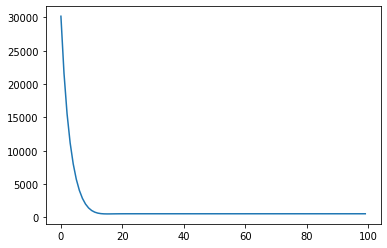

In [87]:
import matplotlib.pyplot as plt 
import copy


def train():
  best_model = None
  best_loss = 0
  losses = []
  for epoch in range(100):
    training_loss=0.0
    for bid, batch in enumerate(train_loader):
      u, i, r = batch
      r = r.float()

      preds = model(u, i)
      loss = criterion(preds.float(), r)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      training_loss += loss.item()
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    losses.append(training_loss)
    if best_model is None or best_loss > loss.item():
      best_loss = loss.item()
      best_model = copy.deepcopy(model)

  plt.plot(losses)
  plt.show()

  return best_model
  
best_model = train()




# Evaluate Model

In [88]:
def test(model):
  test_loss = 0.0
  for bid, batch in enumerate(test_loader):
    u, i, r = batch
    r = r.float()
    preds = model(u, i)
    loss = criterion(preds.float(), r) * u.size(0)
    test_loss += loss.item()
  print(f'Test Loss is {test_loss / len(test_data)}')
with torch.no_grad():
  test(best_model)

Test Loss is 0.7878046470802486
